# Q2 Ans

## 1. Let us import necessary modules

In [1]:
import torch
from torch import nn
import torchvision
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from time import time
import matplotlib.pyplot as plt
from pathlib import Path

## 2. Display version of SDKs and setup device agnostic code

In [2]:
# Print the versions of PyTorch and torchvision being used
print(
    f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}"
)

# Set the random seed for reproducibility
torch.manual_seed(42)

# Setup device-agnostic code to use GPU if available, else CPU
if torch.cuda.is_available():
    device = "cuda"
    # Use CUDA tensors by default
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    device = "cpu"
    # Use CPU tensors by default
    torch.set_default_tensor_type(torch.FloatTensor)

print(f"Using device: {device}")

PyTorch version: 2.4.1+cu121
torchvision version: 0.19.1+cu121
Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


## 3. Load the dataset and set the batch size

In [3]:
# Setup training data using FashionMNIST dataset
train_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

# Setup testing data using FashionMNIST dataset
test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

# Define batch size for DataLoader
BATCH_SIZE = 32

# Create DataLoader for training data with shuffling and appropriate generator for CUDA
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    generator=torch.Generator(device="cuda") if device == "cuda" else None,
)

# Create DataLoader for testing data without shuffling
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    generator=torch.Generator(device="cuda") if device == "cuda" else None,
)



100%|██████████| 26421880/26421880 [00:03<00:00, 8158919.57it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173491.78it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:07<00:00, 590657.22it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5688165.70it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## 4. Create the model class

In [4]:
class FashionMNISTVAE(nn.Module):
    """
    Variational Autoencoder (VAE) model for the FashionMNIST dataset.
    """

    def __init__(self, input_shape=784, hidden_units=512, output_shape=128):
        """
        Initializes the VAE with encoder and decoder networks.

        Args:
            input_shape (int): Size of the input layer (default: 784 for 28x28 images).
            hidden_units (int): Number of hidden units in the encoder (default: 512).
            output_shape (int): Size of the latent space (default: 128).
        """
        super(FashionMNISTVAE, self).__init__()

        # Ensure that input_shape, hidden_units, and output_shape are multiples of 2
        if ((input_shape % 2 != 0) | (hidden_units % 2 != 0) | (output_shape % 2 != 0)):
            raise ValueError("Ensure that all parameters are multiples of 2")

        # Define the encoder network
        self.encoder = nn.Sequential(
            nn.Flatten(),  # Flatten the input image
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=int(hidden_units / 2)),
            nn.ReLU(),
            nn.Linear(in_features=int(hidden_units / 2),
                      out_features=output_shape),
        )

        # Linear layers to compute mean and log variance of the latent space
        self.fc_mu = nn.Linear(output_shape, int(
            output_shape / 4))      # Mean vector
        self.fc_logvar = nn.Linear(output_shape, int(
            output_shape / 4))  # Log variance

        # Define the decoder network
        self.decoder = nn.Sequential(
            nn.Linear(in_features=int(output_shape / 4),
                      out_features=int(hidden_units / 2)),
            nn.ReLU(),
            nn.Linear(in_features=int(hidden_units / 2),
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=input_shape),
            nn.Sigmoid(),  # Sigmoid activation for output to be between 0 and 1
        )

    def encoder_func(self, x):
        """
        Passes input through the encoder and returns mean and log variance.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tuple[Tensor, Tensor]: Mean and log variance tensors.
        """
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparametrization_trick(self, mu, logvar):
        """
        Applies the reparametrization trick to sample from the latent space.

        Args:
            mu (Tensor): Mean tensor.
            logvar (Tensor): Log variance tensor.

        Returns:
            Tensor: Sampled latent vector.
        """
        std = torch.exp(0.5 * logvar)  # Calculate standard deviation
        # Sample epsilon from a standard normal distribution
        eps = torch.randn_like(std)
        return mu + eps * std          # Return the sampled latent vector

    def decoder_func(self, z):
        """
        Passes latent vector through the decoder to reconstruct the input.

        Args:
            z (Tensor): Latent vector.

        Returns:
            Tensor: Reconstructed input.
        """
        return self.decoder(z)

    def forward(self, x):
        """
        Forward pass through the VAE.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tuple[Tensor, Tensor, Tensor]: Reconstructed input, mean, and log variance.
        """
        mu, logvar = self.encoder_func(
            x)          # Encode input to get mean and log variance
        # Sample latent vector using reparametrization trick
        z = self.reparametrization_trick(mu, logvar)
        return self.decoder(z), mu, logvar         # Decode the latent vector




## 5. Create the loss function

In [5]:
def FashionMNISTVAE_loss_func(org, recon, mu, logvar):
    """
    Computes the VAE loss function as the sum of reconstruction loss and KL divergence.

    Args:
        org (Tensor): Original input tensor.
        recon (Tensor): Reconstructed input tensor.
        mu (Tensor): Mean tensor from the encoder.
        logvar (Tensor): Log variance tensor from the encoder.

    Returns:
        Tensor: Total loss.
    """
    # Reconstruction loss using binary cross entropy
    reconstruction_loss = nn.functional.binary_cross_entropy(
        recon.view(-1, 28 * 28), org.view(-1, 28 * 28), reduction='sum'
    )

    # KL divergence loss to regularize the latent space
    kl_loss = -0.5 * torch.sum(1 + logvar - (mu ** 2) - torch.exp(logvar))

    return reconstruction_loss + kl_loss



## 6. Create a function to plot decoded images

In [6]:
def plot_reconstructed_images(model, n_images=10):
    """
    Generates and plots reconstructed images from the VAE's decoder.

    Args:
        model (nn.Module): Trained VAE model.
        n_images (int): Number of images to generate and plot (default: 10).
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        # Generate a latent vector `z` with the size expected by the decoder
        z = torch.randn(n_images, 4)  # 4 is the size expected by the decoder

        # Pass the latent vector through the decoder to generate images
        generated = model.decoder_func(z)

        # Reshape the generated output to be 28x28 images with 1 channel
        generated = generated.view(-1, 1, 28, 28)

        # Move the generated images to the CPU if using CUDA
        if model.decoder[0].weight.is_cuda:
            generated = generated.to('cpu')

    # Plot the generated images using matplotlib
    fig, axes = plt.subplots(1, n_images, figsize=(n_images, 1))
    for i in range(n_images):
        # Display each image in grayscale
        axes[i].imshow(generated[i].squeeze(), cmap='gray')
        axes[i].axis('off')  # Hide the axis
    plt.waitforbuttonpress()  # Wait for a button press to close the plot



## 7. Create a a function to train and save the model

In [7]:
def train_save_model(epochs=50, input_shape=784, hidden_units=256, output_shape=16, lr=0.001, MODEL_PATH=Path("./Q2/saved_models").absolute()):
    """
    Trains the VAE model and saves the trained model's state dictionary.

    Args:
        epochs (int): Number of training epochs (default: 50).
        input_shape (int): Size of the input layer (default: 784 for 28x28 images).
        hidden_units (int): Number of hidden units in the encoder (default: 256).
        output_shape (int): Size of the latent space (default: 16).
        lr (float): Learning rate for the optimizer (default: 0.001).
        MODEL_PATH (Path): Folder to store the trained model
    """
    # Create models directory
    MODEL_PATH.mkdir(parents=True, exist_ok=True)

    # Define the model save path with a timestamp
    MODEL_NAME = f"FashionMNISTVAE_model.pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    torch.autograd.set_detect_anomaly(
        True)  # Enable anomaly detection for debugging
    model = FashionMNISTVAE(
        hidden_units=hidden_units, output_shape=output_shape
    ).to(device=device)  # Initialize and move the model to the appropriate device

    # Initialize the Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    start_time = time()  # Record the start time

    for epoch in range(epochs):
        epoch_start_time = time()  # Record the start time of the epoch
        model.train()  # Set the model to training mode
        tot_loss = 0
        tot_reconstruction_loss = 0
        tot_kl_loss = 0

        for data, _ in train_dataloader:
            data = data.to(device)  # Move data to the appropriate device
            optimizer.zero_grad()   # Reset gradients

            recon, mu, logvar = model(data)  # Forward pass through the model

            # Calculate reconstruction loss using binary cross entropy
            reconstruction_loss = nn.functional.binary_cross_entropy(
                recon.view(-1, 28 * 28), data.view(-1, 28 * 28), reduction='sum'
            )

            # Calculate KL divergence loss
            kl_loss = -0.5 * \
                torch.sum(1 + logvar - (mu ** 2) - torch.exp(logvar))

            # Total loss is the sum of reconstruction loss and KL divergence
            loss = reconstruction_loss + kl_loss

            # Accumulate losses for monitoring
            tot_loss += loss.item()
            tot_reconstruction_loss += reconstruction_loss.item()
            tot_kl_loss += kl_loss.item()

            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update model parameters

        # Print epoch statistics
        print(
            f'Epoch [{epoch+1}/{epochs}], '
            f'Total Loss: {tot_loss / len(train_dataloader.dataset):.4f}, '
            f'Reconstruction Loss: {tot_reconstruction_loss / len(train_dataloader.dataset):.4f}, '
            f'KL Divergence Loss: {tot_kl_loss / len(train_dataloader.dataset):.4f}, '
            f'Time taken: {time() - epoch_start_time:.2f}s'
        )

    # Print total training time
    print(f"Time taken for {epochs} epochs is {time() - start_time:.2f}s")

    # Save the trained model's state dictionary
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(
        obj=model.state_dict(),  # Save only the model's learned parameters
        f=MODEL_SAVE_PATH
    )



## 8. Create a function to load the saved model

In [8]:
def load_saved_model(path, input_shape=784, hidden_units=256, output_shape=16):
    """
    Loads a saved VAE model from the specified path.

    Args:
        path (str or Path): Path to the saved model's state dictionary.
        input_shape (int): Size of the input layer (default: 784 for 28x28 images).
        hidden_units (int): Number of hidden units in the encoder (default: 256).
        output_shape (int): Size of the latent space (default: 16).

    Returns:
        nn.Module: Loaded VAE model.
    """
    loaded_model = FashionMNISTVAE(
        hidden_units=hidden_units, output_shape=output_shape
    )
    loaded_model.load_state_dict(torch.load(path))  # Load the state dictionary
    loaded_model = loaded_model.to(
        device="cuda" if torch.cuda.is_available() else "cpu"
    )  # Move the model to the appropriate device
    return loaded_model



## 9. Main Code

<ipython-input-8-9125bf4b4287>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(path))  # Load the state dictionary


KeyboardInterrupt: 

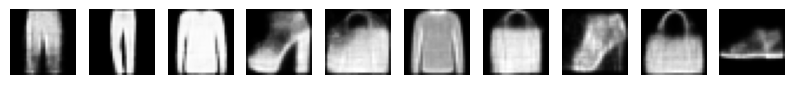

In [10]:
directory_path = Path("./saved_models_1").absolute()
# Uncomment the line below to train and save the model
# train_save_model(epochs=50, MODEL_PATH=directory_path)

# Path to the saved model (update the path as needed)
saved_model_path = directory_path / "FashionMNISTVAE_model.pth"

# Load the saved model
model = load_saved_model(saved_model_path)

# Plot reconstructed images using the loaded model
plot_reconstructed_images(model=model)